# Creative machine learning - Machine Learning

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [first definition](#definition) on the concept of machine learning
2. An introduction to a simple problem of [linear regression](#regression)
4. A detailed implementation of [simple linear regression](#linear)
3. An explanation on [model capacity and overfitting](#capacity)
4. Two [exercises](#exercises) to explore regression and classification
4. An introduction to the [audio datasets](#audio) that we will use

<a id="definition"></a>
## Defining machine learning

In all natural process, there exists complex relations between sets $\mathcal{X} \mapsto \mathcal{Y}$. This can relate some objects with their names, or a cause to a consequence. In most cases, _we do not know the precise relations_ between these sets, all we have is _observations_ such as pairs $(x,y)$, composed of input data $x \in \mathcal{X}$, which have a corresponding expected output $y \in \mathcal{Y}$. The overarching goal of machine learning is to approximate such _unknown processes_ as a function $\mathcal{F}_{\theta}$, which _transforms_ input data $x$ into output data $y$.


<center>
<img src="images/01_machine_learning_basic.png" align="center"/>
</center>

Hence, machine learning aims to understand and model the relationship between some (usually complex and high-dimensional) inputs $\mathbf{x}\in\mathcal{X}\subset\mathbb{R}^{\mathcal{X}}$ and outputs $\mathbf{y}\in\mathcal{Y}\subset\mathbb{R}^{\mathcal{Y}}$, given by a set of data examples $\mathcal{D}=\left\{(x_1,y_1),\cdots,(x_N,y_N)\right\}$. This is achieved by defining a parametric model $f_{\mathbf{\theta}}\in\mathcal{F}$ inside a family of functions $\mathcal{F}$, which depends on parameters $\mathbf{\theta} \in \mathbf{\Theta}$ and that could approximate the underlying relationship. The _learning_ aspect refers to the adjustment of the parameters $\mathbf{\theta}$ in order to obtain the best approximation of the given task
$$
\begin{equation}
f_{\mathbf{\theta}}(\mathbf{x}) = \bar{\mathbf{y}}\approx \mathbf{y}.
\end{equation}
$$

Hence, the major elements that we have to define in any machine learning problems are
1. **Dataset** : $\mathcal{D}=\left\{(x_1,y_1),\cdots,(x_N,y_N)\right\}$. This dataset has to be representative of the relation $f:\mathcal{X} \mapsto \mathcal{Y}$ that we are looking to model
2. **Model** : Our parametric approximation $\bar{\mathbf{y}} = f_{\mathbf{\theta}}(\mathbf{x})$, where the choice of family $f_{\mathbf{\theta}}\in\mathcal{F}$ is critical
3. **Loss** : $\mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$ allows to measure the amount of errors made by our model
4. **Optimization** : Method to find $\theta^{*}\in\Theta$ so that our model minimizes the loss
$$\theta^{*}= \underset{\theta}{\text{argmin }} \mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$$


To observe this idea in simple setups, we are going to use the `numpy` library and also initialize the homemade course library `cml` and style for future plotting and exercise. We also set the random generator to a fixed point with `rng = np.random.RandomState(1)`, to ensure reproducibility

In [ ]:
# Base imports
import numpy as np
import matplotlib.pyplot as plt
from cml.plot import initialize_bokeh
from cml.panel import initialize_panel
from jupyterthemes.stylefx import set_nb_theme
from bokeh.io import show
initialize_bokeh()
initialize_panel()
set_nb_theme("onedork")
rng = np.random.RandomState(1)

<a id="regression"></a>
## Simple learning problem

Imagine that a certain process somewhere follows the form of a quadratic relationship

$$
 y = a x^{2} + bx + c 
$$

In this case, all the **unknown parameters** are that of a polynomial model, therefore we have $\theta = \{a, b, c\}$. However, this is clearly an ideal (clean) case, whereas in natural observations, there might be some noise in our observations
$$
 y = a x^{2} + bx + c +\epsilon \quad \mbox{with} \quad \epsilon \in [-0.1, 0.1]
$$

An example of such noisy observations for different parameters is given below

In [ ]:
# Parameters to our function
eps = 1
a, b, c = 5, 2, 0
# Generating the corresponding data
x_data = np.linspace(0, 1, 100)
poly = np.poly1d([a, b, c])
epsilon = np.random.uniform(-eps, eps, x_data.shape)
y = poly(x_data) + epsilon

In [ ]:
from cml.plot import center_plot, scatter
plot = (center_plot(scatter(x_data, y, title="Simple quadratic problem", toolbar_location="left")))
plot

Now our main problem is that this function can follow different types of parameters

In [ ]:
params = [[5, -5, 4], [-2, 1, 0], [0.1, 1, 1]]
# Generating the x axis
x_data = np.linspace(0, 1, 100)
plots = []
for p in range(len(params)):
    poly = np.poly1d(params[p])
    epsilon = np.random.uniform(-eps, eps, x_data.shape)
    y = poly(x_data) + epsilon
    plots.append(scatter(x_data, y, title="Problem "+(str(p+1))))

In [ ]:
from bokeh.models import Div
from bokeh.layouts import column, row
plot = center_plot(column(Div(text = "Observing different problems", style={'font-size': '250%'}), row(*plots)))
plot

In real-life settings, this function can also have different levels of noise, as exemplified in the following code.

In [ ]:
params = [3, 0, 1]
noise_levels = [0.1, 1.0, 8.0]
# Generating the x axis
x_data = np.linspace(0, 1, 100)
plots = []
for p in range(len(noise_levels)):
    poly = np.poly1d(params)
    epsilon = np.random.uniform(-noise_levels[p],noise_levels[p],x_data.shape)
    y = poly(x_data) + epsilon
    plots.append(scatter(x_data, y, title="Problem "+(str(p+1))))

In [ ]:
plot = center_plot(column(Div(text = "Different amounts of noise", style={'font-size': '250%'}), row(*plots)))
plot

To summarize, we will have some observations of a function, and we would like to optimize a function that gets as close as possible to the real function that generated this data. Here, we plot the real function and also _subsample_ our number of observations (having only a few points to find the corresponding function)

In [ ]:
# Generating the data and subsampling
x_all = np.linspace(0, 1, 100); x_plot = np.linspace(0, 1, 100)
rng.shuffle(x_all); x_data = np.sort(x_all[:50])
poly = np.poly1d([3,0,1])
# Adding some external noise
epsilon = np.random.uniform(-0.2,0.2,x_data.shape)
y = poly(x_data)+ epsilon
p = scatter(x_data, y, title="Learning problem with groundtruth")
p.line(x_plot, poly(x_plot), line_width=6, line_alpha=0.6, color="green", legend_label=r"True function")
plot = (center_plot(p))
plot

### Summarizing our observations (interactive)



In [ ]:
from cml.tasks import RegressionPolynomial
explorer = RegressionPolynomial()
explorer.render()

## Using learning libraries (`scikit-learn`)

To get a first grip on what machine learning does, we will rely on the `scikit-learn` library. This contains already coded models and learning procedure, that will allow us to _learn_ the parameters of this unknown function.

Here we already know that we want to use a `PolynomialFeatures` model to perfom `LinearRegression` and that this polynomial should be of degree 2.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# Our data to fit
X = x_data[:, np.newaxis]
# Degree of our polynomial
degree = 30;
# Create our polynomial model for regression
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# Fit the parameters of this model
model.fit(X, y);

Now that we have trained the model, we can perform _predictions_ from it, meaning that we can infer the output of the function at values that we did not observe originally.

In [ ]:
# Inference points (not observed)
X_plot = x_plot[:, np.newaxis]
# Predict the values
y_plot = model.predict(X_plot)
# Compute the error of our model at observed points
Y_model_err = np.sqrt(np.mean(np.square(y-model.predict(X))))
print(f'Model error : {Y_model_err}')
# Plot the result
p = scatter(x_data, y, title="Training a scikit-learn model")
p.line(x_plot, poly(x_plot), line_width=6, line_alpha=0.6, color="red", legend_label=r"Trained model")
plot = (center_plot(p))
plot

In [ ]:
from cml.tasks import RegressionPolynomialSolver
explorer = RegressionPolynomialSolver()

In [ ]:
def solve(x, y, degree):
    X = x[:, np.newaxis]
    # Create our polynomial model for regression
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    # Fit the parameters of this model
    model.fit(X, y)
    # Predict the values
    x_predict = np.linspace(np.min(x), np.max(x), 200)[:, np.newaxis]
    y_model = model.predict(x_predict)
    return x_predict[:, 0], y_model #np.array(jnp.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

<a id="linear"></a>
# Simple linear regression 

As discussed previously, regression allows to model the relationships that exist between inputs $\mathbf{x}\in\mathbb{R}^{n}$ and a continuous output $y\in\mathbb{R}$. In the case of **linear** regression, we assume that the data that we observe comes from a linear relationship in the input, so that
$$y = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n + \epsilon$$
with $\epsilon$ exhibiting the *observation noise* (also called *residual error*) that is always present in measurements.

To understand how we could learn a model approximating this relationship, we start with the case of *simple* linear regression, where $\mathbf{x}\in\mathbb{R}$. This implies that our model will follow
$$\bar{y} = w_0 + w_1 x$$

We will measure the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}\left( \bar{\mathbf{y}},\theta \right) = \sum_{i=1}^{n} \left| y_{i} - \bar{y}_{i} \right|^{2} = \sum_{i=1}^{n} \left| y_{i} - (w_{0} + w_{1} x_{i}) \right|^{2}$$

Then our goal is to find the most adequate set of parameters $\theta = \{w_{0}, w_{1}\}$, which are those that minimize the MSE loss defined previously. Therefore, we aim to obtain
$$\theta^{*}= \underset{\theta}{\text{argmin }} \mathcal{L}\left( \bar{\mathbf{y}}, \mathbf{y} \mid f_{\theta}, \theta \right)$$

To do so, we will implement the **gradient descent** algorithm discussed in the course.

## Manual implementation - `NumPy`

We start by performing a *full manual implementation*, in the sense that we need to manually derive the gradient in order to apply the gradient descent updates. To do so, we will rely on [NumPy](https://numpy.org/), which is a fundamental library for numerical computing offering support for N-dimensional arrays and scientific computing tasks, such as linear algebra, statistical analysis, and matrix manipulation. We strongly encourage you to learn NumPy through the set of [tutorials](https://numpy.org/learn/). For the sake of this introductory tutorial, we will provide the explanation for all of the functions that we will use in this first exercise. After that exercise, we will assume for the rest of the course that knowledge of Numpy should be found online. 

We start by import libraries (`NumPy`) and set a random seed to ensure that the random number generator produces always a reproducible series of random numbers.

**Used functions**
- `np.random.seed`: sets the seed for the NumPy random number generator. [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html)

In [ ]:
import numpy as np
np.random.seed(42)

In [ ]:
?np.random.seed

### Generate a synthetic dataset.

For the sake of this exercise, we will generate the data ourselves, so that we know the true values that we are looking for in advance. Hence, we define a linear relationship following
$$y = w^{t}_0 + w^{t}_1 x + \epsilon$$

**Used functions**
- `np.random.rand`: generates an array of random numbers uniformly distributed over [0, 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html)
- `np.random.randn`: generates an array of random numbers from the standard normal distribution (mean 0, variance 1). [Documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
- `np.ones`: generates an array of ones with a specified shape. [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)
- `np.c_`: concatenates arrays along the second axis. [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.c_.html)

In [ ]:
true_w0 = 2
true_w1 = 3
x_min = 0
x_max = 1
n_obs = 100
x_data = np.linspace(x_min, x_max, n_obs)
y = true_w1 * x_data + true_w0

### Computing the MSE loss

We will measure the errors made by our model by using the Mean Squared Error (MSE) loss, defined as 
$$\mathcal{L}_{MSE}\left( \bar{\mathbf{y}},\theta \right) = \sum_{i=1}^{n} \left| y_{i} - \bar{y}_{i} \right|^{2} = \sum_{i=1}^{n} \left| y_{i} - (w_{0} + w_{1} x_{i}) \right|^{2}$$

This will allow us to evaluate the performances of our model, but is also the basis for the following gradient descent algorithm.

**Used functions**
- `np.sum`: computes the sum of the provided array (optionally across a provided `axis`). [Documentation](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

In [ ]:
def mse_loss(y, y_bar):
    return np.sum((y - y_bar) ** 2)

### Implement the gradient descent algorithm.

As seen in the course Initialize the weight $w_1$ and bias $w_0$ to small random values
1. Evaluate the predictions made by our model 
$$\hat{y} = w_{1}x + w_0$$
2. Compute the mean squared error (MSE) loss between the predicted values and the ground truth labels: 
$$\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^n (\bar{y_i} - y_i)^2$$
3. Compute the gradients of the loss with respect to the weight and bias (see derivation in the course)
$$\frac{\partial \mathcal{L}}{\partial w_1} = \sum_{i} 2 * (\bar{y}_{i} - y_{i})*x_{i}$$
$$\frac{\partial \mathcal{L}}{\partial w_0} = \sum_{i} 2 * (\bar{y}_{i} - y_{i})$$
4. Update the weights and bias using the gradients and a learning rate $\eta$: 
$$w_1 \leftarrow w_1 - \eta \frac{\partial \mathcal{L}}{\partial w_1}$$ 
$$w_0 \leftarrow w_0 - \eta \frac{\partial \mathcal{L}}{\partial w_0}$$

In [ ]:
# Parameters
n_iter = 1000
lr = 0.001
def gradient_descent(x, y, n_iter, lr):
    # Initialize the parameters
    w_1 = np.random.randn()
    w_0 = np.random.randn()
    # Perform gradient descent
    for i in range(n_iter):
        # 1. Calculate the predictions
        y_bar = w_1 * x + w_0
        # 2. Compute the loss
        loss = mse_loss(y, y_bar)
        # 3. Calculate the gradients
        dw_1 = 2 * np.sum((y_bar - y) * x)
        dw_0 = 2 * np.sum((y_bar - y))
        # 4. Update the parameters
        w_1 -= lr * dw_1
        w_0 -= lr * dw_0
    return w_1, w_0
w_1, w_0 = gradient_descent(x_data, y, n_iter, lr)
print(w_1)
print(w_0)

### Visualize the results.

We can see how well our model fits to the observed data by plotting it against the observed samples.

In [ ]:
p = scatter(x_data, y, title="Simple linear regression")
p.line(x_data, w_1 * x_data + w_0, line_width=6, line_alpha=0.6, color="red", legend_label=r"Learned model")
plot = (center_plot(p))
plot

### Observing our solution interactively

In the following code, you can observe the behavior of the model by playing interactively with the properties of the original problem. 

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> Note that each change in the properties of the original problem requires to run the gradient descent algorithm entirely each time.

</div>

In [ ]:
from cml.tasks import RegressionLinearSolver
explorer = RegressionLinearSolver()
def solve(x, y):
    w_1, w_0 = gradient_descent(x, y, n_iter, lr)
    x_predict = np.linspace(np.min(x), np.max(x), 200)
    y_model = w_1 * x_predict + w_0
    return np.array(x_predict), np.array(y_model) #np.array(np.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further
> **Exercise 1 \[Learning rate\]**: Experiment with different learning rates (e.g., 0.001, 0.01, 0.1, 1) and observe how they affect the convergence of the gradient descent algorithm. Plot the convergence history (cost function value vs. iteration) for each learning rate.

> **Exercise 2 \[Initialization\]**: Experiment with different initializations of the coefficients (zeros, random values, etc.) and observe their impact on the convergence of the gradient descent algorithm.

> **Exercise 3 \[Variants\]**: Implement and compare different variants of gradient descent, such as stochastic gradient descent (SGD) and mini-batch gradient descent. Analyze their convergence properties and computational efficiency.

> **Exercise 4 \[Regularization\]**: Implement Lasso and Ridge regression with gradient descent by incorporating the regularization terms into the cost function and gradient calculations. Compare their performance with the standard linear regression implementation and analyze their impact on the learned coefficients.


</div>

## Discovering automatic differentiation - `JAX`

The previous implementation required us to perform manual differentiation of our loss function to understand how to update the parameters. However, large developments have been made in the field of **automatic differentiation**. 

The recent library [JAX](https://github.com/google/jax) extends NumPy with this automatic differentiation feature (*autograd*), while providing a functional approach to numerical computing, allowing for easy gradient computation and just-in-time (JIT) compilation. Its ability to handle complex and custom gradients makes JAX particularly well-suited for advanced research projects. Similar to NumPy, we strongly encourage you to learn JAX through the set of [tutorials](https://jax.readthedocs.io/en/latest/), but we will also provide here the explanation for all of the functions that we will use in this first exercise. After that, we will assume that knowledge of JAX should be found online. 

Note that `JAX` has been thought as an extension of `NumPy`, therefore an extremely large portion of its API simply mirrors the `NumPy` functions by adding automatic differentiation features to it.

**Used functions**
- `random.PRNGKey`: function to generate a key for the pseudorandom number generator. [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, random
key = random.PRNGKey(42)

### Dataset.

We can simply keep our previous approach to generating the dataset but we will rely on `jnp.ndarray` instead of `np.ndarray`. We also provide the code for splitting the dataset between a `training` and `validation` dataset, as discussed in the course

**Used functions**
- `random.split`: function to split a PRNGKey into a list of subkeys [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html)
- `random.uniform`: function to generate an array of uniformly distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html)
- `random.normal`: function to generate an array of normally distributed random numbers [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.normal.html)

In [ ]:
true_w0 = 2
true_w1 = 3
key_0, key_1, key = random.split(key, 3)
x_data = random.uniform(key_0, (100,))
y = true_w0 + true_w1 * x_data + (random.normal(key_1, (100,)) * 0.2)

In [ ]:
# Splitting our dataset
train_size = int(0.8 * len(x_data))
x_train, x_valid = x_data[:train_size], x_data[train_size:]
y_train, y_valid = y[:train_size], y[train_size:]

### Loss function

Similarly Define the cost function and its gradient.

**Used functions**
- `jnp.mean`: function to compute the mean of an array [Documentation](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.mean.html)

In [ ]:
def loss_function(x, y, w_1, w_0):
    y_pred = x * w_1 + w_0
    residuals = y_pred - y
    return jnp.mean(residuals**2)


**Used functions**
- `jit`: function to compile a function for faster execution [Documentation](https://jax.readthedocs.io/en/latest/jit.html)
- `grad`: function to compute the gradient of a function [Documentation](https://jax.readthedocs.io/en/latest/jax.html#jax.grad)

In [ ]:
grad_loss_function = jit(grad(loss_function, argnums=[2, 3]))

### Implement the gradient descent algorithm.

Note that nowhere in the code do we need to explicitly define the gradients of the different variables. Yet, the optimization will be performed adequately.

In [ ]:
def gradient_descent(key, x, y, lr=0.05, n_iter=1000):
    m = x.shape
    k_0, k_1 = random.split(key, 2)
    w_0 = random.normal(k_0, (1,))
    w_1 = random.normal(k_1, (1,))
    loss_history = []
    for _ in range(n_iter):
        gradients = grad_loss_function(x, y, w_1, w_0)
        #print(gradients[0])
        w_1 -= lr * gradients[0]
        w_0 -= lr * gradients[1]
        loss_history.append(loss_function(x, y, w_1, w_0))
    return w_1, w_0, loss_history

key_gd, key = random.split(key, 2)
w_1, w_0, loss_history = gradient_descent(key_gd, x_train, y_train)
print("Gradient Descent coefficients:", w_1, w_0)

### Evaluate our performances

Thanks to our previous split of the dataset, we are now able to evaluate the performances of our model on *unseen data*, which is the overarching goal of building such machine learning models.

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

y_valid_gd = w_1 * x_valid + w_0
mse_gd = mean_squared_error(y_valid, y_valid_gd)
print("MSE for Gradient Descent:", mse_gd)

### Visualize the results.

As previously we can witness our results, and also evaluate our solution with our interactive solver.

In [ ]:
p = scatter(np.array(x_data), np.array(y), title="Linear regression")
p.line(np.array(x_data), np.array(w_1 * x_data + w_0), line_width=6, line_alpha=0.6, color="red", legend_label=r"Learned model")
plot = (center_plot(p))
plot

In [ ]:
from cml.tasks import RegressionLinearSolver
explorer = RegressionLinearSolver()
global key
key = random.PRNGKey(23)
def solve(x, y):
    global key
    key_gd, key = random.split(key, 2)
    w_1, w_0, loss_history = gradient_descent(key_gd, x, y)
    x_predict = np.linspace(np.min(x), np.max(x), 200)
    y_model = w_1 * x_predict + w_0
    return np.array(x_predict), np.array(y_model) #np.array(jnp.zeros(y_model.shape))

explorer.solve = solve
explorer.render()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further

> You are encouraged to experiment in a similar way as outlined for NumPy with different learning rates, maximum number of iterations, and regularization techniques, as well as compare the performance (both accuracy and speed) of the implemented algorithms with `scikit-learn` built-in linear regression functions.

</div>

<a id="capacity"></a>
## Understanding model capacity and selection


In real-life problem, we are aiming to find the parameters of a model, but we do not really know what is the _real_ function underlying this process. So what we can decide to select _any_ function of _any_ **capacity** (complexity of the function). One of the problem with that, is that if we have a too simple function, it will _underfit_ (it is not complex enough for our observations). On the opposite end, if we have a function which is too complex, it might be able to _fit through all training points exactly_ ... even though there is noise in our observations ! This is examplified in the following

<img src="images/01_soa_function_families.png" align="center"/>

We can observe this idea and play with it directly by trying to find a function approximating our previous observations with a polynomial function chosen to have a degree inside \([1,2,8]\).



Depending on the _capacity_ of the model, what we can observe is that

- `capacity too low   -> underfitting   : prediction variance >  noise variance`
- `adequate capacity  -> good fit       : prediction variance == noise variance`
- `capacity too high  -> overfitting    : prediction variance <  noise variance`


A similar example can be given for a classification problem in two dimensions as follows

<img src="images/01_underfit.png" align="center"/>


# Exercises

In the following, we define the exercises that you should fill for this session. These go further than what we have seen together in the course, but they are based on the exact same principles, simply with slightly more complex definitions. We provide an overall guideline for successfully implementing each of the exercise.

## Exercise 1 - Linear classification

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> In this exercise, we will implement linear classification using NumPy and JAX. The goal of this exercise is to gain a better understanding of how linear classification works and how to implement it ourselves using our two first libraries of choice, namely NumPy and JAX. To complete this exercise, you will need to have a basic understanding of NumPy and JAX. You can use the resources provided in the previous exercises to learn more about these libraries.

We help you out by first defining a simple linear classification problem to solve

</div>

In [17]:
import numpy as np
from sklearn.datasets import make_blobs


def make_dataset_linear_classification():
    # Properties of the problem
    n_observations = 200
    noise = 0.2
    c1_center = [-2, -1]
    c2_center = [2, 1]
    # Create points
    x_coords, y_class = make_blobs(n_samples=n_observations, centers=[
                                   c1_center, c2_center], n_features=2, cluster_std=0.55)
    x_data = x_coords + (noise * np.random.randn(n_observations, 2))
    # x_data = x_coords
    y_classes = y_class
    y_classes[y_classes == 0] = -1
    return x_data, y_classes


<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Implement linear classification with NumPy

> 1. Check the training data with two classes that are linearly separable.
> 2. Initialize weights and bias.
> 3. Implement the forward pass of the linear classifier.
> 4. Implement the hinge loss for classification.
> 5. Derive the gradients (backward pass) of the linear classifier.
> 6. Implement gradient descent to optimize the weights and bias.

</div>

In [18]:
# 0. Common code for NumPy and JAX
import matplotlib.pyplot as plt
import numpy as np


class LinearClassification:
    def __init__(self, x_data, y_classes):
        self.x_data = x_data
        self.y_classes = y_classes
        self.w = np.zeros(2)
        self.b = np.zeros(1)

    def init_weights(self):
        self.w = np.random.randn(2)
        self.b = np.random.randn(1)

    def forward(self, x):
        return np.dot(x, self.w) + self.b

    def classify(self, x):
        return np.where(self.forward(x) > 0, 1, -1)

    def loss(self, x):
        pass

    def grad(self, x):
        pass

    def gradient_descent(self, lr=0.0001, n_iter=1000):
        for i in range(n_iter):
            loss = self.loss(self.x_data, self.y_classes)
            print(f"epoch = {i}, loss={np.sum(loss)}")
            grad_w, grad_b = self.grad(self.x_data, self.y_classes)
            self.w -= lr * grad_w
            self.b -= lr * grad_b

    def plot(self, classify=False):
        # plot data and classification
        plt.scatter(x_data[:, 0], x_data[:, 1], c=self.classify(
            self.x_data) if classify else self.y_classes, alpha=0.5)
        # plot decision boundary
        if self.w.any() or self.b.any():
            fn_x_0 = np.linspace(
                np.min(x_data[:, 0]), np.max(x_data[:, 0]), 100)
            fn_x_1 = np.linspace(
                np.min(x_data[:, 1]), np.max(x_data[:, 1]), 100)
            # Create 2-D grid xlist,ylist values
            fn_X, fn_Y = np.meshgrid(fn_x_0, fn_x_1)
            fn_F = self.w[0] * fn_X + self.w[1] * fn_Y + self.b
            plt.contour(fn_X, fn_Y, fn_F, [0])
        plt.show()


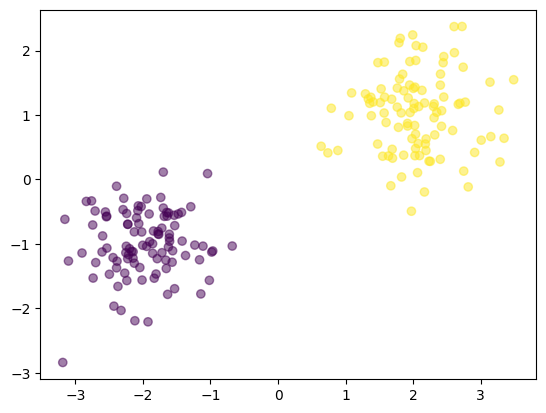

In [19]:
# 1. Check the training data
x_data, y_classes = make_dataset_linear_classification()
linear_class_void = LinearClassification(x_data, y_classes)
linear_class_void.plot()

In [20]:
# 2. Initialize the weights and bias
linear_class_void.init_weights()

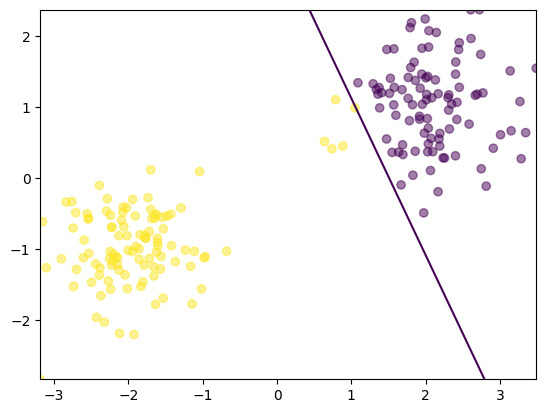

In [21]:
# 3. Implement forward pass
# see (0) common code forward part
linear_class_void.plot(classify=True)

In [22]:
# 4. Implement loss function
class LinearClassificationHingeLoss(LinearClassification):
    def loss(self, x, y):
        y_pred = self.forward(x)
        return np.sum(np.maximum(0, 1 - y * y_pred))

    def grad(self, x, y):
        y_pred = self.forward(x)
        grad_coefficient = np.where(y_classes * y_pred >= 1, 0, 1)
        grad_w = np.sum((grad_coefficient * (-y*x.T)).T, axis=0)
        grad_b = np.sum((grad_coefficient * -y).T, axis=0)
        return grad_w, grad_b


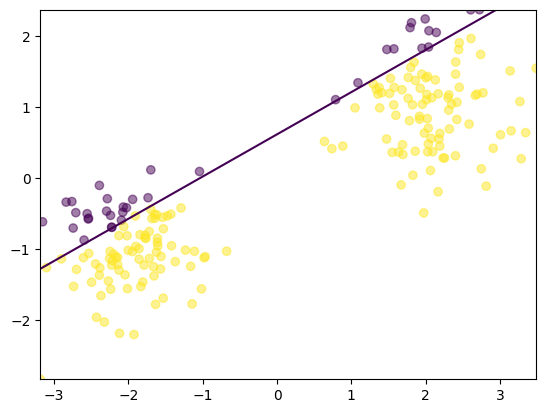

epoch = 0, loss=210.1729296514324
epoch = 1, loss=200.6624589855134
epoch = 2, loss=191.69424188920345
epoch = 3, loss=182.9749859188408
epoch = 4, loss=174.55983248940913
epoch = 5, loss=166.43171540133187
epoch = 6, loss=158.64881578092172
epoch = 7, loss=151.38884009264356
epoch = 8, loss=144.47836541140623
epoch = 9, loss=137.78227314369093
epoch = 10, loss=131.28899419921578
epoch = 11, loss=125.14316136200046
epoch = 12, loss=119.24945407387017
epoch = 13, loss=113.82498207061813
epoch = 14, loss=108.56500381457009
epoch = 15, loss=103.49030033461324
epoch = 16, loss=98.71166219380336
epoch = 17, loss=94.25632387901294
epoch = 18, loss=90.0547462509506
epoch = 19, loss=86.22452083080461
epoch = 20, loss=82.53317505342469
epoch = 21, loss=79.16237470643006
epoch = 22, loss=75.79157435943542
epoch = 23, loss=72.46440906727517
epoch = 24, loss=69.18190495472138
epoch = 25, loss=65.97067284187895
epoch = 26, loss=63.038796690199916
epoch = 27, loss=60.29242193890425
epoch = 28, loss=

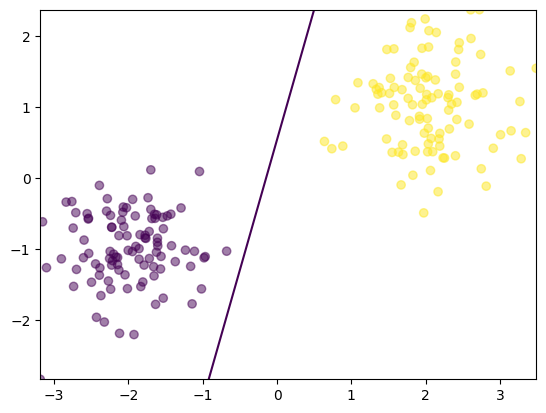

In [27]:
# 5. Derive the gradients
# 6. Implement gradent descent
linear_class = LinearClassificationHingeLoss(x_data, y_classes)
linear_class.init_weights()
linear_class.plot(classify=True)
linear_class.gradient_descent()
linear_class.plot(classify=True)

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further (optional)
> Try to replace the Hinge loss by the cross-entropy loss in your implementation

</div>

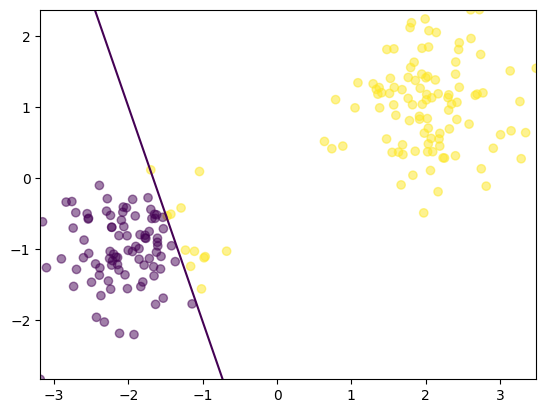

epoch = 0, loss=67.96726613899742
epoch = 1, loss=62.27757534611518
epoch = 2, loss=56.74170633415859
epoch = 3, loss=51.416219562405644
epoch = 4, loss=46.357977105266755
epoch = 5, loss=41.59257308738552
epoch = 6, loss=37.33173655998317
epoch = 7, loss=33.81274972630722
epoch = 8, loss=30.72718383975234
epoch = 9, loss=28.02157932784132
epoch = 10, loss=25.572146433208168
epoch = 11, loss=23.444434993012933
epoch = 12, loss=21.656029245195555
epoch = 13, loss=19.942142097922087
epoch = 14, loss=18.412781036682517
epoch = 15, loss=17.06991274841829
epoch = 16, loss=15.868509000267835
epoch = 17, loss=14.762062479563856
epoch = 18, loss=13.853685549839788
epoch = 19, loss=13.003821114522882
epoch = 20, loss=12.265898833259095
epoch = 21, loss=11.573762324586665
epoch = 22, loss=10.924419460790212
epoch = 23, loss=10.362742630659913
epoch = 24, loss=9.852897663788298
epoch = 25, loss=9.38767404307969
epoch = 26, loss=8.934175600361861
epoch = 27, loss=8.539421668475551
epoch = 28, loss

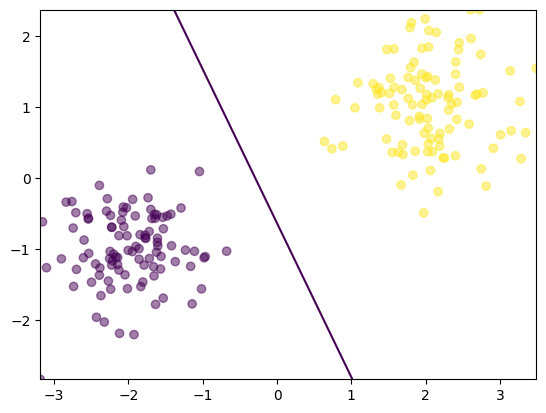

In [30]:
class LinearClassificationCrossEntropy(LinearClassification):
    def loss(self, x, y):
        y_pred = self.forward(x)
        return - np.average(y * np.log(y_pred) + (1 - y) * np.log(1-y_pred))

    def grad(self, x):
        y_pred = self.forward(x)
        grad_w = np.average(x.T * (y_pred - y))
        grad_b = y_pred - y
        return grad_w, grad_b

linear_class_ce = LinearClassificationCrossEntropy(x_data, y_classes)
linear_class.init_weights()
linear_class.plot(classify=True)
linear_class.gradient_descent()
linear_class.plot(classify=True)

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Implement linear classification with JAX

> 1. Initialize weights and bias.
> 2. Define the loss function using the jax.nn.softmax_cross_entropy_with_logits function.
> 3. Implement gradient descent to optimize the weights and bias.

</div>

In [31]:
import jax.numpy as jnp
import jax

class LinearClassificationHingeLossJAX(LinearClassificationHingeLoss):
    def loss_raw(_, x, y, w, b):
        y_pred = jnp.dot(x, w) + b
        return jnp.sum(jnp.maximum(0, 1-y*y_pred))

    def loss(self, x, y):
        return self.loss_raw(x, y, self.w, self.b)

    grad_raw = jax.jit(jax.grad(loss_raw, argnums=[3,4], allow_int=True), static_argnums=0)

    def grad(self, x, y):
        return self.grad_raw(x, y, self.w, self.b)

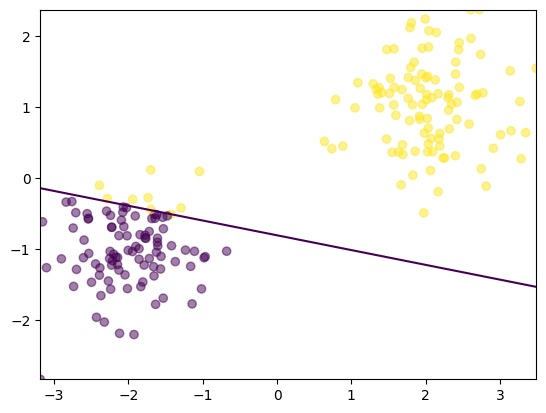

epoch = 0, loss=89.33749389648438
epoch = 1, loss=77.76130676269531
epoch = 2, loss=68.106201171875
epoch = 3, loss=59.43082809448242
epoch = 4, loss=52.0147819519043
epoch = 5, loss=45.15570831298828
epoch = 6, loss=39.11083221435547
epoch = 7, loss=33.83753967285156
epoch = 8, loss=29.4790096282959
epoch = 9, loss=25.69460678100586
epoch = 10, loss=22.6307373046875
epoch = 11, loss=20.0146484375
epoch = 12, loss=17.924102783203125
epoch = 13, loss=15.946076393127441
epoch = 14, loss=14.147679328918457
epoch = 15, loss=12.67593765258789
epoch = 16, loss=11.475897789001465
epoch = 17, loss=10.522780418395996
epoch = 18, loss=9.69887924194336
epoch = 19, loss=8.925176620483398
epoch = 20, loss=8.231751441955566
epoch = 21, loss=7.625864028930664
epoch = 22, loss=7.144276142120361
epoch = 23, loss=6.744450569152832
epoch = 24, loss=6.367486000061035
epoch = 25, loss=6.015979766845703
epoch = 26, loss=5.683597564697266
epoch = 27, loss=5.389256000518799
epoch = 28, loss=5.150777816772461


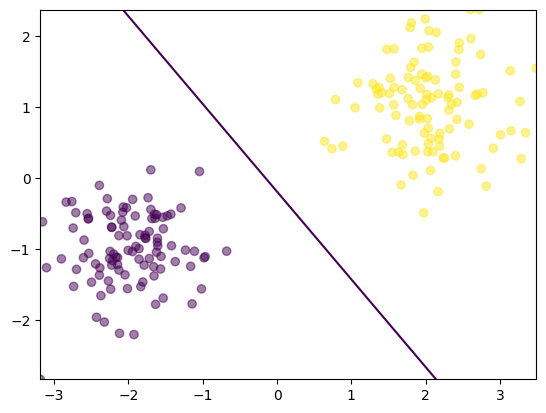

In [33]:
linear_class_jax = LinearClassificationHingeLossJAX(x_data, y_classes)
linear_class_jax.init_weights()
linear_class_jax.plot(classify=True)
linear_class_jax.gradient_descent()
linear_class_jax.plot(classify=True)

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.3 - Compare the results of the NumPy and JAX implementations.
> 1. Plot the decision boundary for each implementation.
> 2. Compare the training time and accuracy of each implementation.

</div>

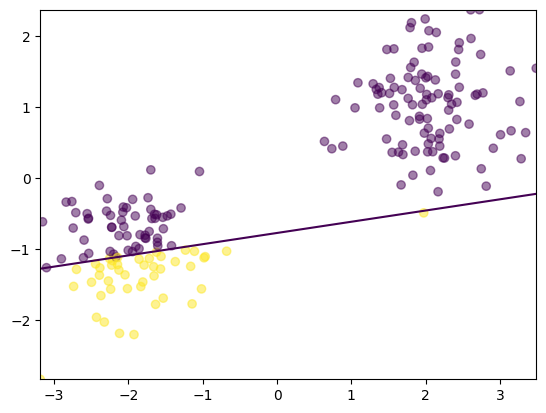

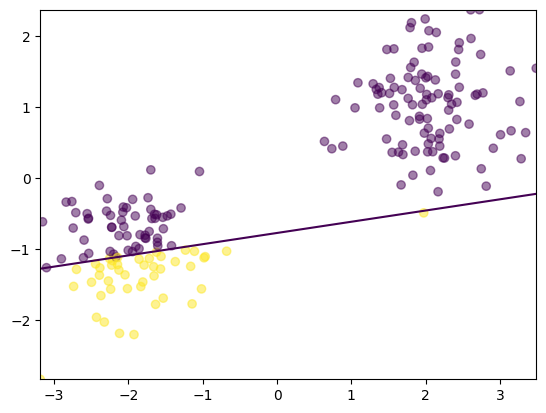

epoch = 0, loss=523.3622927903691
epoch = 1, loss=508.1479563321053
epoch = 2, loss=493.32440617993706
epoch = 3, loss=478.5008560277688
epoch = 4, loss=463.77371158970277
epoch = 5, loss=449.33647222163074
epoch = 6, loss=435.1695333685807
epoch = 7, loss=421.3171695138527
epoch = 8, loss=407.8646140512968
epoch = 9, loss=394.94408943068834
epoch = 10, loss=382.4818909634769
epoch = 11, loss=370.32481020325713
epoch = 12, loss=358.73362235128417
epoch = 13, loss=348.0114963203441
epoch = 14, loss=337.4985751442602
epoch = 15, loss=327.3234086895151
epoch = 16, loss=317.27374989852115
epoch = 17, loss=307.86460083894093
epoch = 18, loss=298.9150476493767
epoch = 19, loss=290.1459414035511
epoch = 20, loss=281.44455024100824
epoch = 21, loss=273.1368260770557
epoch = 22, loss=265.01120734651556
epoch = 23, loss=256.8855886159755
epoch = 24, loss=248.9763163277874
epoch = 25, loss=241.5439268631956
epoch = 26, loss=234.1115373986038
epoch = 27, loss=226.71940826844286
epoch = 28, loss=21

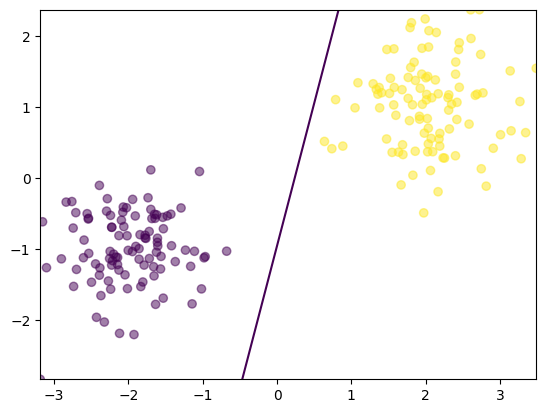

epoch = 0, loss=523.3623046875
epoch = 1, loss=508.1479797363281
epoch = 2, loss=493.3244323730469
epoch = 3, loss=478.5008850097656
epoch = 4, loss=463.77374267578125
epoch = 5, loss=449.3365173339844
epoch = 6, loss=435.16961669921875
epoch = 7, loss=421.31719970703125
epoch = 8, loss=407.86468505859375
epoch = 9, loss=394.9441223144531
epoch = 10, loss=382.48199462890625
epoch = 11, loss=370.3249206542969
epoch = 12, loss=358.73370361328125
epoch = 13, loss=348.0115661621094
epoch = 14, loss=337.4986267089844
epoch = 15, loss=327.323486328125
epoch = 16, loss=317.2738037109375
epoch = 17, loss=307.8646545410156
epoch = 18, loss=298.91510009765625
epoch = 19, loss=290.14599609375
epoch = 20, loss=281.444580078125
epoch = 21, loss=273.1368713378906
epoch = 22, loss=265.01129150390625
epoch = 23, loss=256.88568115234375
epoch = 24, loss=248.97637939453125
epoch = 25, loss=241.54400634765625
epoch = 26, loss=234.11160278320312
epoch = 27, loss=226.7194366455078
epoch = 28, loss=219.6127

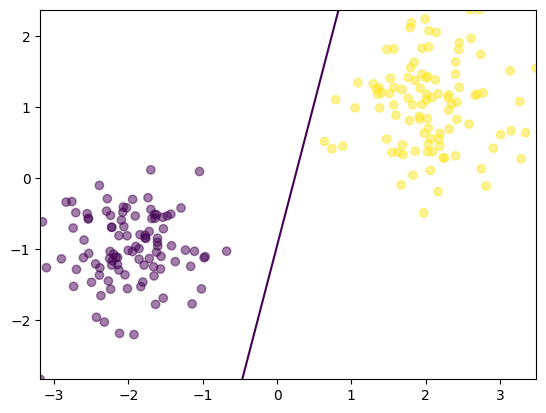

numpy = 32573000ns, jax = 108274000ns
numpy = 1.0, jax = 1.0


In [34]:
import time

# create NumPy and JAX version and use the same weight
linear_class = LinearClassificationHingeLoss(x_data, y_classes)
linear_class.init_weights()
linear_class_jax = LinearClassificationHingeLossJAX(x_data, y_classes)
linear_class_jax.w = np.copy(linear_class.w)
linear_class_jax.b = np.copy(linear_class.b)

linear_class.plot(classify=True)
linear_class_jax.plot(classify=True)

np_start = time.time_ns()
linear_class.gradient_descent()
np_end = time.time_ns()
linear_class.plot(classify=True)

jax_start = time.time_ns()
linear_class_jax.gradient_descent()
jax_end = time.time_ns()
linear_class_jax.plot(classify=True)

print(f"numpy = {np_end - np_start}ns, jax = {jax_end - jax_start}ns")

np_results = linear_class.classify(x_data)
jax_results = linear_class_jax.classify(x_data)
np_accuracy = np.count_nonzero(np_results * y_classes + np.ones(len(np_results))) / len(np_results)
jax_accuracy = np.count_nonzero(jax_results * y_classes + np.ones(len(jax_results))) / len(jax_results)
print(f"numpy = {np_accuracy}, jax = {jax_accuracy}")


<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further (optional)
> Implement a more complex dataset and compare the results of the NumPy and JAX implementations.

</div>

## Exercise 2 - Polynomial regression

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> In this exercise, you will implement polynomial regression using NumPy and JAX. This should be a quite straightforward extension of what we have seen until now. We deliberately removed details of the implementation (list of points to adress) so that you can start defining your first entire machine learning setup by yourself.

</div>

In [12]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyval

def make_dataset_ploynomial_regression(degree=3, samples=100):
    w = np.random.uniform(-10, 10, degree+1)
    x_data = np.random.uniform(-2, 2, samples)[:, np.newaxis]
    epsilon = np.random.uniform(-2,2,x_data.shape)
    y_data = polyval(x_data, w) + epsilon
    return x_data, y_data

class PolynomialRegression:
    def __init__(self, x_data, y_data, n_degree):
        self.x_data = x_data
        self.y_data = y_data
        self.n_degree = n_degree
        self.w = np.zeros(n_degree + 1)

    def init_weights(self):
        self.w = np.random.randn(self.n_degree + 1)

    def forward(self, x):
        return np.polyval(self.w, x)
    
    def loss(self, x, y):
        pass

    def grad(self, x, y):
        pass

    def train(self, lr=0.0001, n_iter=10000):
        for i in range(n_iter):
            loss = self.loss(self.x_data, self.y_data)
            print(f"epoch = {i}, loss={np.sum(loss)}")
            grad = self.grad(self.x_data, self.y_data)
            self.w -= lr * grad

    def plot(self):
        # plot data
        plt.scatter(self.x_data, self.y_data, color='b', alpha=0.5)
        # plot predicted data
        if self.w.any():
            x = np.linspace(-2, 2, 100)
            plt.scatter(x, self.forward(x), color='r', alpha=0.5,linewidths=1)
        plt.show()

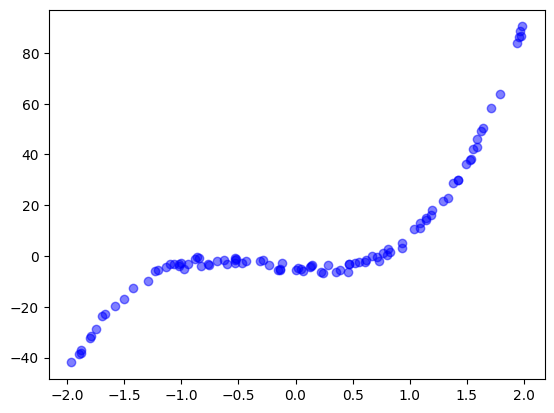

In [13]:
n_degree = 3
x_data, y_data = make_dataset_ploynomial_regression(n_degree)
poly_regres_void = PolynomialRegression(x_data, y_data, n_degree)
poly_regres_void.plot()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.1 - Implement polynomial regression using NumPy with gradient descent.

</div>

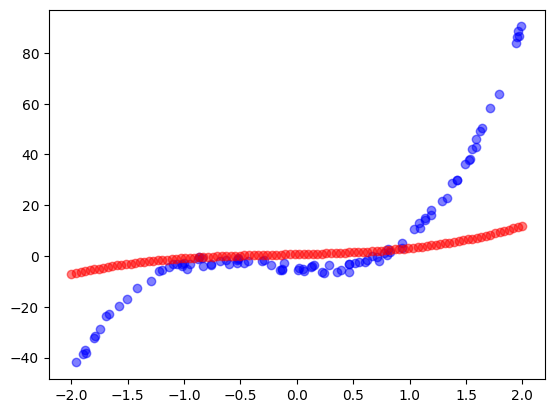

epoch = 0, loss=562.6824822175284
epoch = 1, loss=374.40300551423735
epoch = 2, loss=254.49960699146246
epoch = 3, loss=177.9048634365117
epoch = 4, loss=128.76721937553845
epoch = 5, loss=97.0593238087842
epoch = 6, loss=76.43506930937636
epoch = 7, loss=62.87553316983221
epoch = 8, loss=53.83333855127567
epoch = 9, loss=47.69192027063823
epoch = 10, loss=43.423756157405144
epoch = 11, loss=40.37431645468542
epoch = 12, loss=38.12545439504179
epoch = 13, loss=36.40900008246598
epoch = 14, loss=35.05208448387567
epoch = 15, loss=33.9425211803474
epoch = 16, loss=33.0068702053178
epoch = 17, loss=32.19652293965252
epoch = 18, loss=31.47886220120746
epoch = 19, loss=30.831635392627977
epoch = 20, loss=30.23936336269665
epoch = 21, loss=29.691040382035297
epoch = 22, loss=29.178654132361213
epoch = 23, loss=28.696227487581222
epoch = 24, loss=28.239193164766696
epoch = 25, loss=27.803981445191358
epoch = 26, loss=27.387744895660315
epoch = 27, loss=26.988171700395252
epoch = 28, loss=26.6

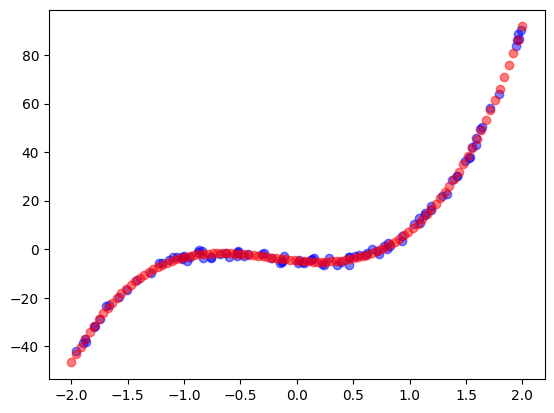

In [14]:
class PolynomialRegressionMSE(PolynomialRegression):
    def loss(self, x, y):
        y_pred = self.forward(x)
        return (np.square(y_pred - y)).mean(axis=0)
    
    def grad(self, x, y):
        y_pred = self.forward(x)
        return 2 * np.sum((y_pred - y) * np.flip(np.power(x, np.arange(self.n_degree+1)), axis=-1), axis=0)
    
poly_regres = PolynomialRegressionMSE(x_data, y_data, n_degree)
poly_regres.init_weights()
poly_regres.plot()
poly_regres.train()
poly_regres.plot()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.2. Implement polynomial regression using JAX with gradient descent.

</div>

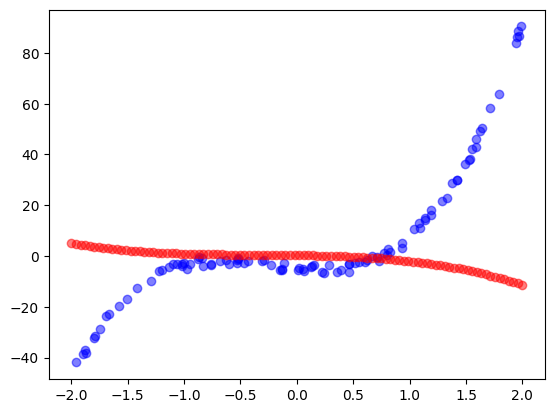

epoch = 0, loss=987.4758911132812
epoch = 1, loss=983.69677734375
epoch = 2, loss=979.9329223632812
epoch = 3, loss=976.184326171875
epoch = 4, loss=972.4507446289062
epoch = 5, loss=968.7324829101562
epoch = 6, loss=965.029052734375
epoch = 7, loss=961.3406982421875
epoch = 8, loss=957.6671752929688
epoch = 9, loss=954.0086669921875
epoch = 10, loss=950.3648071289062
epoch = 11, loss=946.7357788085938
epoch = 12, loss=943.1213989257812
epoch = 13, loss=939.5216674804688
epoch = 14, loss=935.9364013671875
epoch = 15, loss=932.3657836914062
epoch = 16, loss=928.809326171875
epoch = 17, loss=925.2674560546875
epoch = 18, loss=921.739990234375
epoch = 19, loss=918.2265625
epoch = 20, loss=914.7274169921875
epoch = 21, loss=911.2423095703125
epoch = 22, loss=907.7715454101562
epoch = 23, loss=904.314697265625
epoch = 24, loss=900.8717041015625
epoch = 25, loss=897.4428100585938
epoch = 26, loss=894.0276489257812
epoch = 27, loss=890.6264038085938
epoch = 28, loss=887.2387084960938
epoch = 

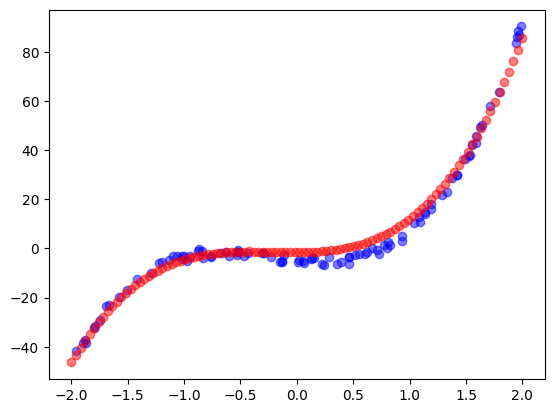

In [15]:
import jax
import jax.numpy as jnp

class PolynomialRegressionMSE_JAX(PolynomialRegression):
    def loss_raw(_, x, y, w):
        y_pred = jnp.polyval(w, x)
        return jnp.mean(jnp.square(y_pred - y))
    def loss(self, x, y):
        return self.loss_raw(x, y, self.w)
    
    grad_raw = jax.jit(jax.grad(loss_raw, argnums=[3]), static_argnums=0)
    def grad(self, x, y):
        return self.grad_raw(x, y, self.w)[0]
    
poly_regres_jax = PolynomialRegressionMSE_JAX(x_data, y_data, n_degree)
poly_regres_jax.init_weights()
poly_regres_jax.plot()
poly_regres_jax.train()
poly_regres_jax.plot()

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 2.3 - Compare the results of both implementations and the speed of the optimization algorithm.

</div>

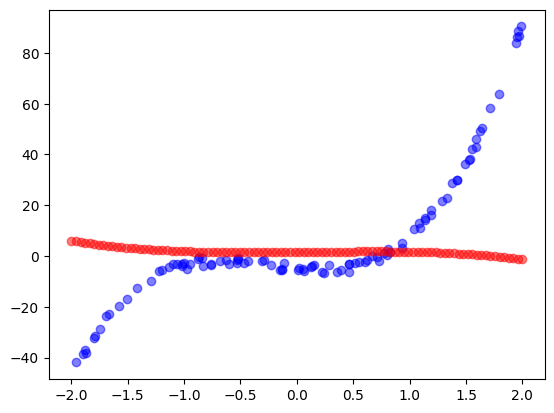

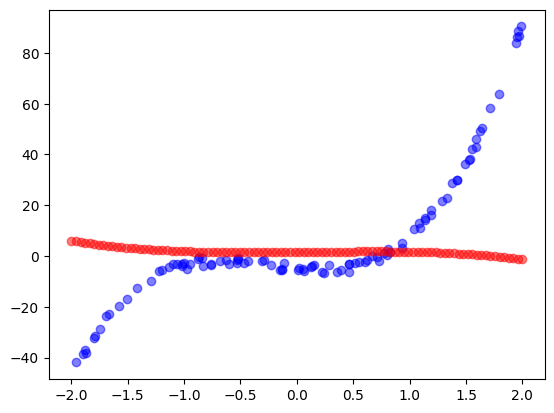

epoch = 0, loss=814.601740926988
epoch = 1, loss=533.798992387711
epoch = 2, loss=355.6284265863233
epoch = 3, loss=242.37850439440908
epoch = 4, loss=170.2139263540209
epoch = 5, loss=124.06718959222123
epoch = 6, loss=94.41114034986954
epoch = 7, loss=75.21986525392454
epoch = 8, loss=62.68033498613023
epoch = 9, loss=54.378353979025086
epoch = 10, loss=48.78416956371974
epoch = 11, loss=44.927405883660306
epoch = 12, loss=42.1916169420552
epoch = 13, loss=40.18442065127976
epoch = 14, loss=38.65539133025247
epoch = 15, loss=37.444132434953715
epoch = 16, loss=36.44742331644169
epoch = 17, loss=35.59842263282284
epoch = 18, loss=34.85349429028347
epoch = 19, loss=34.18385387183149
epoch = 20, loss=33.57026468447897
epoch = 21, loss=32.99966408956422
epoch = 22, loss=32.46301246713955
epoch = 23, loss=31.953917317520578
epoch = 24, loss=31.46774941448179
epoch = 25, loss=31.001071843686177
epoch = 26, loss=30.551268455979493
epoch = 27, loss=30.116299807657406
epoch = 28, loss=29.6945

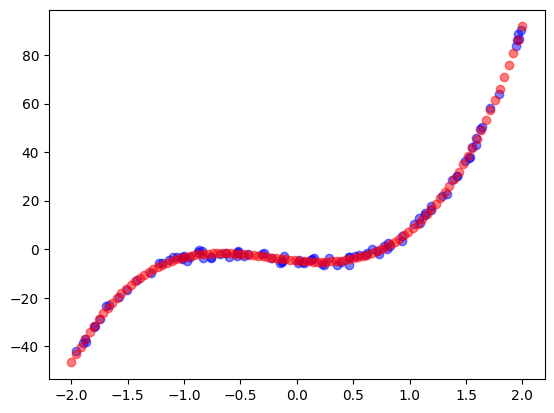

epoch = 0, loss=814.601806640625
epoch = 1, loss=811.4783935546875
epoch = 2, loss=808.3677978515625
epoch = 3, loss=805.2698364257812
epoch = 4, loss=802.1846923828125
epoch = 5, loss=799.1118774414062
epoch = 6, loss=796.0516357421875
epoch = 7, loss=793.0037231445312
epoch = 8, loss=789.9684448242188
epoch = 9, loss=786.9453735351562
epoch = 10, loss=783.9345092773438
epoch = 11, loss=780.9362182617188
epoch = 12, loss=777.9498901367188
epoch = 13, loss=774.9757690429688
epoch = 14, loss=772.0137329101562
epoch = 15, loss=769.063720703125
epoch = 16, loss=766.1257934570312
epoch = 17, loss=763.1996459960938
epoch = 18, loss=760.2855834960938
epoch = 19, loss=757.3833618164062
epoch = 20, loss=754.4928588867188
epoch = 21, loss=751.6141967773438
epoch = 22, loss=748.7471923828125
epoch = 23, loss=745.891845703125
epoch = 24, loss=743.0482788085938
epoch = 25, loss=740.216064453125
epoch = 26, loss=737.3954467773438
epoch = 27, loss=734.5862426757812
epoch = 28, loss=731.78857421875
e

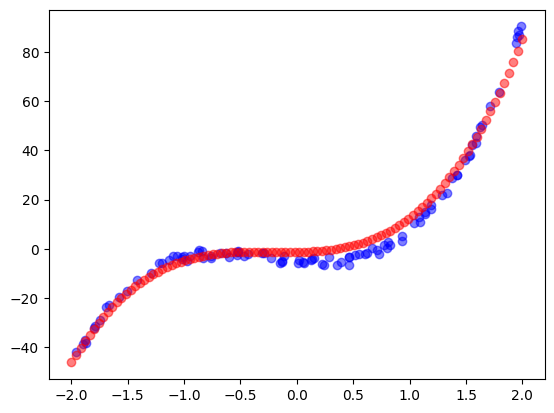

numpy = 409968000ns, jax = 563892000ns
numpy = [1.26916633], jax = 12.514640808105469


In [16]:
import time

# create NumPy and JAX version and use the same weight
poly_regres = PolynomialRegressionMSE(x_data, y_data,n_degree)
poly_regres.init_weights()
poly_regres_jax = PolynomialRegressionMSE_JAX(x_data, y_data,n_degree)
poly_regres_jax.w = np.copy(poly_regres.w)

poly_regres.plot()
poly_regres_jax.plot()

np_start = time.time_ns()
poly_regres.train()
np_end = time.time_ns()
poly_regres.plot()

jax_start = time.time_ns()
poly_regres_jax.train()
jax_end = time.time_ns()
poly_regres_jax.plot()

print(f"numpy = {np_end - np_start}ns, jax = {jax_end - jax_start}ns")

np_loss = poly_regres.loss(x_data, y_data)
jax_loss = poly_regres_jax.loss(x_data, y_data)
print(f"numpy = {np_loss}, jax = {jax_loss}")


<a id="audio"></a>
# Audio applications

In order to test our algorithms on audio and music data, we will work with several datasets. We will both be using well-known state-of-art datasets (through the TF dataset system). But first, we will rely on a simple dataset (`Musclefish`) that should be downloaded on your local computer first from this [link](https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA)

**The following set of instructions will perform that automatically for you :)**

In [ ]:
!curl https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA/download/musclefish.zip --output musclefish.zip
!unzip musclefish.zip
!mkdir data
!mv musclefish data/

## Dataset details

  |**Type**|*Origin*|
  |-------:|:---------|
  |**Classification**|[*MuscleFish*](http://knight.cis.temple.edu/~vasilis/Courses/CIS750/Papers/muscle_fish.pdf) dataset|
  |**Music-speech**|[*MIREX Recognition*](http://www.music-ir.org/mirex/wiki/2015:Music/Speech_Classification_and_Detection) set|
  |**Source separation**|[*SMC Mirum*](http://smc.inesctec.pt/research/data-2/) dataset|
  |**Speech recognition**|[*CMU Arctic*](http://festvox.org/cmu_arctic/) dataset|

**Unzip the file and place the `musclefish` folder inside a `data` folder in the root of this notebook**
For the first parts of the tutorial, we will mostly rely solely on the classification dataset. In order to facilitate the interactions, we provide a dataset class called `AudioSupervisedDataset` that will allow to import all audio datasets along the tutorials. This class also contains a set of holders and will allow us to perform batch-wise gradient descent.

```Python
class AudioSupervisedDataset():
    """
    Helper class to import datasets
    % class_path  : Path to the dataset (string)
    % type       : Type of dataset (string: 'classify', 'plain', 'metadata')
    """ 
    audio_files
    labels
    labels_names
    num_examples 
    num_classes 
```

We also provide a simplified function `import_dataset` that is demonstrated below.

***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**_Exercise_**  

  1. Launch the import procedure and check the corresponding structure
  2. Code a count function that prints the name and number of examples for each classes 

</div>

***

In [ ]:
from cml.data import import_dataset, AudioSupervisedDataset
data_path = "data/"
batch_size = 16
# Instantiate the dataset class
train_dataset = import_dataset(data_path, "musclefish", 'train', batch_size=batch_size)
# Generate a batch of data from the train dataset
batch_x, batch_y = next(train_dataset)
# Print the shape of the input and output batch tensors
print(batch_x.shape)  # (16, 44100)
print(batch_y.shape)  # (16,)

In [ ]:
#%% Q-0.1.2 - Count function to print the number of examples in each class along with class label

n_batch = 0
train_dataset._reset_generator()
for batch_x, batch_y in iter(train_dataset):
    n_batch += 1
    ######################
    # YOUR CODE GOES HERE
    ######################

print(n_batch)

### Preprocessing

We will rely on a set of spectral transforms that allow to obtain a more descriptive view over the audio information. As most of these are out of the scope of the machine learning course, we redirect you to a [signal processing course](https://ccrma.stanford.edu/~jos/sasp/) proposed by [Julius O. Smith](https://ccrma.stanford.edu/~jos/).  

The following functions to compute various types of transforms are given as part of the basic audio dataset class, in the `cml.data.audio` package

  |**Name**|*Transform*|
  |-------:|:----------|
  |`stft`       |[Short-term Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)|
  |`mel`  |[Mel scale](https://en.wikipedia.org/wiki/Mel_scale) transform|
  |`chroma` |[Chromas vector](https://en.wikipedia.org/wiki/Harmonic_pitch_class_profiles)|
  |`cqt`        |[Constant-Q](https://en.wikipedia.org/wiki/Constant_Q_transform) transform|

In order to perform the various computations, we provide the following function, in the `AudioSupervisedDataset` which performs the different transforms on a complete dataset.  

``` Python
dataset.transform(index, name)
    """ index   : Specific index in our dataset """
    """ name    : Name of the transform to apply """

# The name can be selected in 
"stft"      # Power spectrum (STFT)
"mel"       # Spectrum in Mel scale
"chroma"    # Chroma vectors
"cqt"       # Constant-Q transform
```


***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**Exercise**  

  1. Launch the transform computation procedure and check the corresponding structure
  2. For each class, select a random element and plot its various transforms on a single plot. You should obtain plots similar to those shown afterwards.
  3. For each transform, try to spot major pros and cons of their representation.
  
</div>

***

In [ ]:
# 0.2 - Pre-process the audio to obtain spectral transforms 
power_spec = train_dataset.transform(0, "stft")

In [ ]:
#%% Q-0.2.2 - Plot the various transforms 

######################
# YOUR CODE GOES HERE
######################


### Features

<div markdown = "1">

As you might have noted from the previous exercice, most spectral transforms have a very high dimensionality, and might not be suited to exhibit the relevant structure of different classes. To that end, we provide a set of functions for computing several spectral features in the `cml.data` package, we redirect interested readers to this [exhaustive article](http://recherche.ircam.fr/anasyn/peeters/ARTICLES/Peeters_2003_cuidadoaudiofeatures.pdf) on spectral features computation.

  |**File**|*Transform*|
  |-------:|:----------|
  |`spectral_centroid`|Spectral centroid|
  |`spectral_bandwidth`|Spectral bandwidth|
  |`spectral_contrast`|Spectral contrast|
  |`spectral_flatness`|Spectral flatness|
  |`spectral_rolloff`|Spectral rolloff|

Once again, we provide a function to perform the computation of different features on a complete set. Note that for each feature, we obtain the temporal evolution in a vector. Therefore, for further learning tasks, if you wish to obtain simplified spaces, you might need to compute the mean and standard deviation of each feature.

``` Python
dataset.feature(index, name)
    """ index   : Specific index in our dataset """
    """ name    : Name of the feature to obtain """

# Name can be chosen inside the following
"loudness"    # Loudness
"centroid"    # Spectral centroid
"bandwidth"   # Spectral bandwidth
"contrast"    # Spectral contrast
"flatness"    # Spectral flatness
"rolloff"     # Spectral rolloff

```

***
<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

**Exercise**

  1. Launch the feature computation procedure and check the corresponding structure
  2. This time for each class, superimpose the plots of various features on a single plot, along with a boxplot of mean and standard deviations. You should obtain plots similar to those shown afterwards.
  3. What conclusions can you make on the discriminative power of each feature ?
  4. Perform scatter plots of the mean features for all the dataset, while coloring different classes.
  5. What conclusions can you make on the discriminative power of mean features ?

</div>

***

In [ ]:
# 0.3 - Compute temporal spectral features
power_spec = train_dataset.feature(0, "centroid")

In [ ]:
#%% Q-0.3.2 - Plot the various features 

# Use these styles for boxplot
boxprops=dict(linewidth=3, color='white')
whiskerprops=dict(linewidth=3, color='white')
medianprops=dict(linewidth=2.5, color='firebrick')
flierprops = dict(markeredgecolor='white', markerfacecolor='firebrick')

######################
# YOUR CODE GOES HERE
######################


In [ ]:
#%% Q-0.3.4 - Observe the distribution of classes for different features

# This allows to use 3D rendering in matplotlib
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(12,8))
# Create a vector of random colors for each class
colorVect = np.zeros((3, len(data_struct["class_names"])));
for c in range(len(data_struct["class_names"])):
    colorVect[:,c] = np.random.rand(3);

######################
# YOUR CODE GOES HERE
######################


That's it for this tutorial, now remember that we can use any form of description (features) as a basis for learning algorithms. We will see in the next tutorial what we an do with these features.